In [ ]:
'''
URJC / GIA / Aprendizaje Automático 1 / Curso 23-24
alfredo.cuesta@urjc.es
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

np.set_printoptions(precision=2)
pd.set_option("display.precision", 4)
seed = 1460

# Naive Bayes

El clasificador _Naive Bayes_ (NB), "Bayes Ingenuo" en castellano, es el resultado de imponer dos condiciones a la hora de construir el modelo de verosimilitud.
1. Todos los ejemplos provienen de la misma distribución y son independientes entre sí.<br>
A esta condición se le denomina **iid** (_independientes e identicamente distribuidos_).
2. Las características son variables aleatorias independientes.


## Ejemplos iid

La primera condición es muy leve. <br>
Prácticamente siempre que se trabaja con datos tabulados sin orden se cumple.

## Características independientes

La segunda condición es **muy fuerte**.<br>
Es muy frecuente que dos características tengan una relación entre ellas de modo que, al considerarlas independientes, estamos simplificando su modelo.

Cuando dos variables aleatorias $~X, Y~$  se consideran independientes entonces su probabilidad conjunta es el producto de la probabilidad de cada una, es decir:
$~p(X,Y) = p(X)p(Y).$

Si consideramos que cada característica es una variable aleatoria independiente, entonces el modelo de verosimilitud para los ejemplos de la clase $k$ es:
$
p({\bf X}|y=k) = \prod\nolimits_{j=1}^D p(x_j|y=k).
$

Tomando logaritmos para evitar los problemas numéricos en el ordenador, tenemos

$$
\log p({\bf X}|y=k) = \prod\limits_{j=1}^D \log p(x_j|y=k)
$$

# Algoritmo para construir el modelo de verosimilitud NB

- Separar los ejenplos según su clase.
- Para cada clase diferente $k$ :
  - Para cada característica de la tabla de ejemplos $x_j$:
    1. Elegir la distribución de probabilidad $p(x_j|y=k; ~ \xi_{[j,k]}),~$ <br>
    donde $\xi_{[j,k]}$ son los parámetros de dicha distribución.
    2. Estimar los parámetros $\xi_{[j,k]}^*$ a partir de los valores de la característica $x_j$ para la clase $k$.

$\quad\longrightarrow$ El modelo de versomilitud de la clase $k$ es:
  $$\log p({\bf X}|y=k) = \sum\limits_{j=1}^D p(x_j|y=k; ~ \xi_{[j,k]}^*).$$


    


## Ejemplo de un NB-Bernoulli

Si una característica $j$ solo puede tomar dos valores, es decir $~x_j\in\{0,1\},~$ entonces su distribución de probabilidad es Bernoulli, y por tanto
$$
\log p(x_j|y=k) =
\log \mathrm{Ber}\left( x_j |  y=k; ~\xi_{[j,k]} \right).
$$

Los parámetros de una distribución Bernoulli son el recuento de veces que aperece cada posibilidad.

Primero vamos a realizar el ejercicio en Excel.<br>
La imagen de abajo se corresponde con el fichero `xtra_NBC_Ejercicio.xlsx`, disponible en el aula virtual.

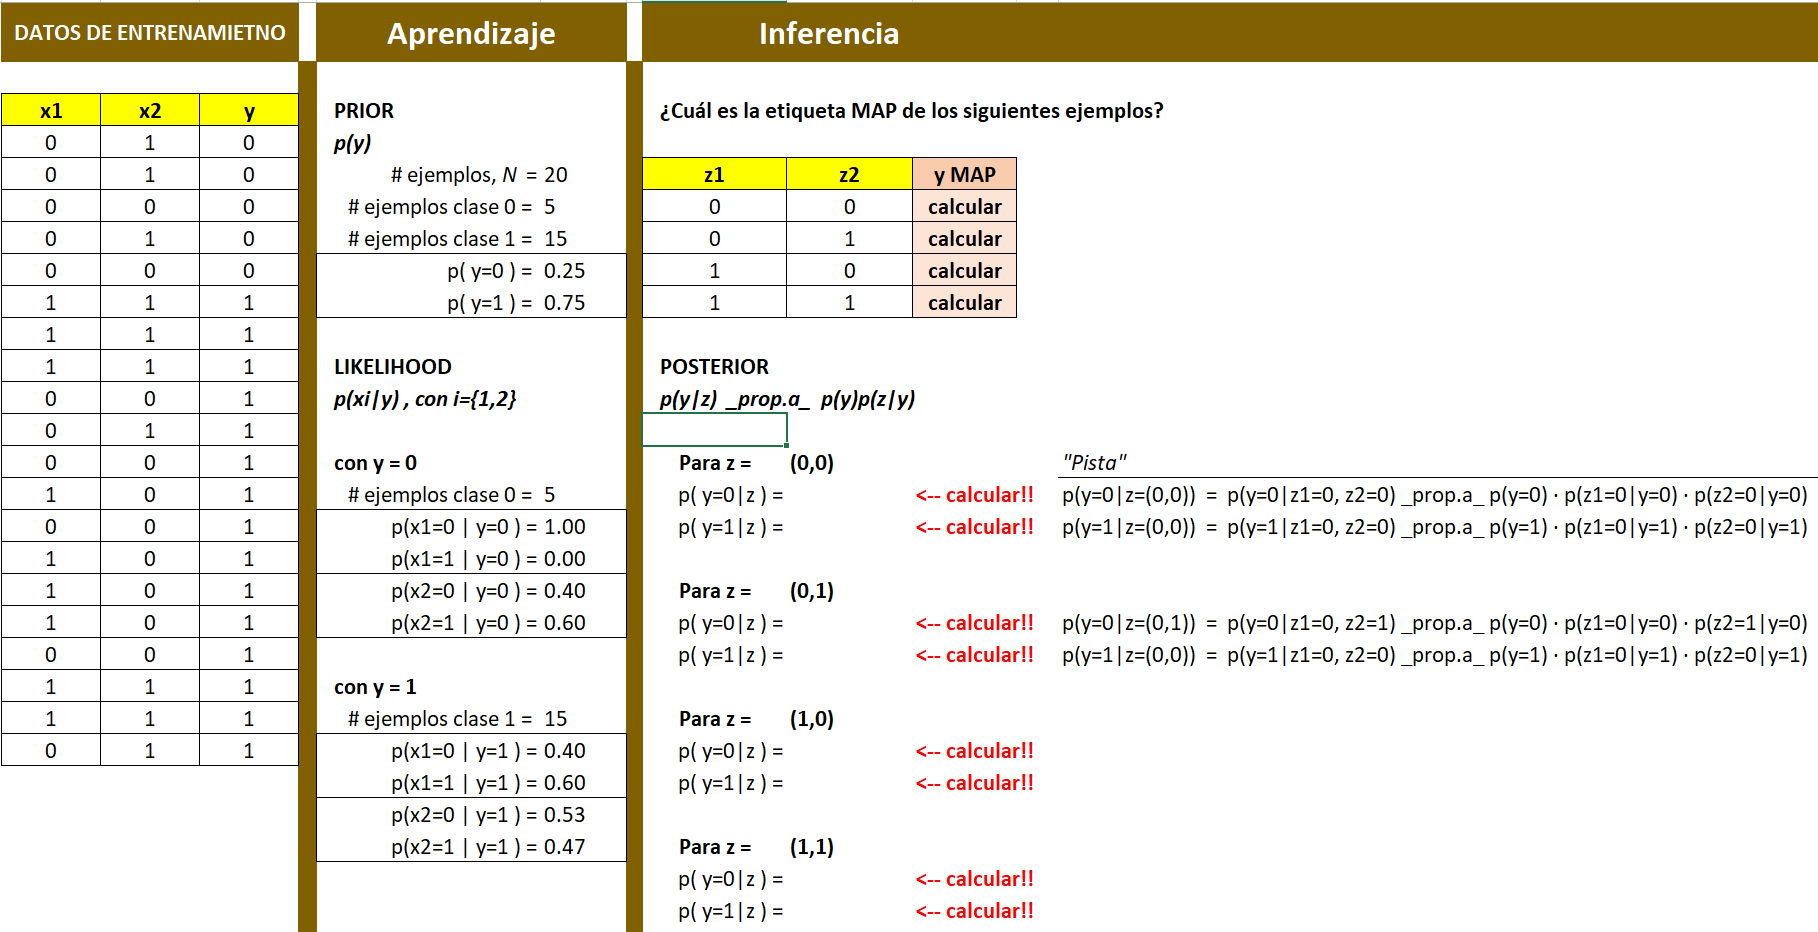

Una vez que lo hemos entendido, a realizar una codificación en Python.

In [ ]:
#%% ---- # 1. Cargar/Crear datos

num_rows = 100
num_columns = 5

# Generate random binary data (0 or 1)
random_data = np.random.randint(2, size=(num_rows, num_columns))

# Create column names
column_names = [f"x_{i}" for i in range(num_columns)]
column_names[0] = 'label'

# Create the DataFrame
fullSet = pd.DataFrame(random_data, columns=column_names)

N,D = fullSet.shape
print(f'Conjunto de datos con {N} filas, {D-1} características')

features = fullSet.columns[1:]
label    = fullSet.columns[0]


Conjunto de datos con 100 filas, 4 características


In [ ]:
#%% ---- # 2. Separar Entrenamiento y Test
test_size = 0.2
trainX, testX, trainY, testY = train_test_split(fullSet[features], fullSet[label],
                                                stratify = fullSet[label],
                                                test_size=test_size,
                                                random_state=seed)

In [ ]:
#%% ---- # 3. Modelo a priori
class Prior:

  def __init__(self, params=[], label_set=[]):
    if (len(params)>0) & (len(label_set)>0):
      self.params = pd.DataFrame({'p(y)':params}, index=label_set)
    return

  def fit(self, Y):
    label_set = Y.unique()
    apriori = []
    for k in label_set:
      N_k = np.sum(Y==k)
      apriori.append(N_k/Y.shape[0])
    self.params = pd.DataFrame({'p(y)':apriori}, index=label_set)
    return

  def predict_logP(self):
    logP_Y = np.log(self.params).sort_index()
    logP_Y.columns=['logP(y)']
    return logP_Y


In [ ]:
#%% ---- # 4. Modelo de verosimilitud (Likelihood)
class Likelihood:

  def __init__(self):
    return

  def fit(self, X, y):
    self.labels = np.sort( y.unique() )
    self.num_labels =  self.labels.size
    self.N = y.shape[0]
    params_ = []
    for j in X.columns:
      for k in self.labels:
        #- Creo un dataframe donde cada fila contiene:
        #  - nombre de la característica,
        #  - valor de la característica,
        #  - valor de la etiqueta,
        #  - prob. del valor de la característica dado el valor de la etiqueta
        count = np.sum(X[j]==k)
        params_.append([j, 0, k, 1-count/self.N])
        params_.append([j, 1, k, count/self.N])
    self.params = pd.DataFrame(params_,
                               columns = ['feat.', 'feat.value', 'label', 'p(x_j|y_k)'])
    self.params.set_index(['feat.', 'feat.value', 'label'], inplace=True)
    return

  def predict_logP(self, X):
    column_names = [f'logP(x|y={k})' for k in self.labels]
    logP_XgivenY = pd.DataFrame(columns=column_names) #<- creo solo las columnas vacias
    for k in self.labels:
      logP_forY=[]
      for i,row in X.iterrows():
        logP = 0
        for j in row.index:
          logP = logP + np.log(self.params['p(x_j|y_k)'].loc[j, row[j], k])
        logP_forY.append(logP)
      column_selected = f'logP(x|y={k})'
      logP_XgivenY[column_selected] = logP_forY
    logP_XgivenY.set_index(X.index, inplace=True)
    return logP_XgivenY


In [ ]:
#%% ---- # 5. Estimación de la etiqueta Max. A Posteriori
def labelMAP(prior, likelihood):
  labels = prior.index.to_list()
  column_names = [f'logP(y={k}|x)' for k in labels]
  posterior = pd.DataFrame(columns=column_names)
  for k in labels:
    col = column_names[k]
    posterior[col] = (prior['logP(y)'][1]
                     + likelihood[f'logP(x|y={k})'])
  #- calculo de la etiqueta MAP
  y_pred = posterior
  y_pred['max'] = y_pred.max(axis=1)
  for col in y_pred.columns[:-1]:
    y_pred[col] = (y_pred[col]==y_pred['max'])*1
  y_pred.drop(columns=['max'], inplace=True)
  column_names = [f'y={k}?' for k in labels]
  y_pred.columns = column_names
  return y_pred, posterior


In [ ]:
#%% ----Script----

P = Prior()
P.fit(trainY)
prior = P.predict_logP()

L = Likelihood()
L.fit(trainX, trainY)
likelihood = L.predict_logP(testX)

y_pred, posterior = labelMAP(prior, likelihood)

print(pd.DataFrame( confusion_matrix(testY, y_pred['y=1?']) ))

#%%


   0  1
0  6  5
1  4  5


## Ejemplo de una NB-Gaussiano

Si una característica $j$ tiene una distribución normal $~x_j\sim\mathcal{N}(x_j; \mu, \sigma),~$ los parámetros son la media y la desviación.

En el fichero `xtra_NBC_Ejercicio.xlsx` tenemos una hoja con un ejemplo para distribuciones normales o gaussianas.

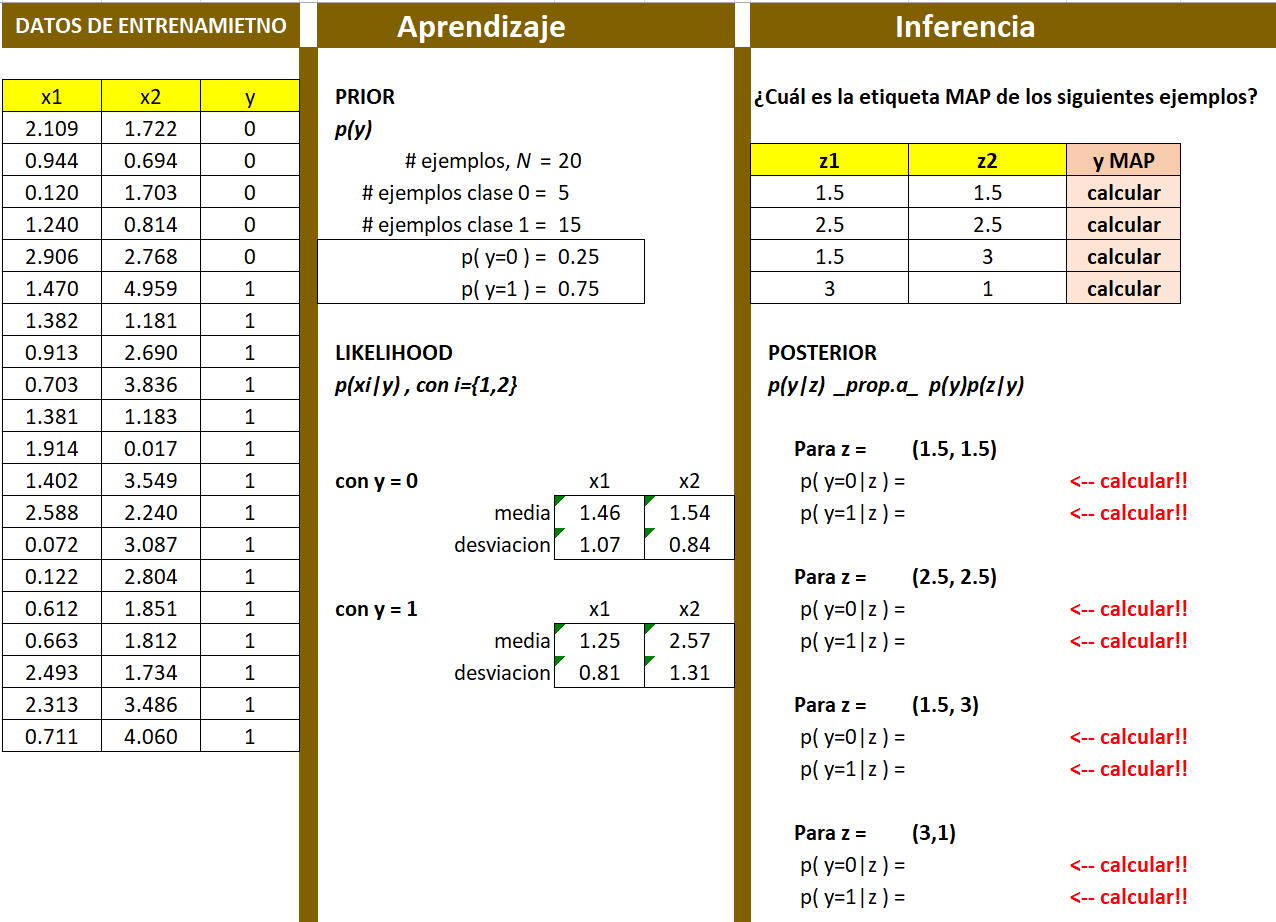

# Ejercicio



Codificar el NB-Gaussiano en Python

### NPHA

El conjunto de datos [_National Poll on Healthy Aging_ (NPHA)](https://archive.ics.uci.edu/dataset/936/national+poll+on+healthy+aging+(npha)) tiene el objetivo de predecir el número de médicos que una parsona mayor (consultada a través de una encuesta) ha visitado en un año. <br>

La URL del fichero comprimido es <br>
$\quad$ `https://archive.ics.uci.edu/static/public/936/national+poll+on+healthy+aging+(npha).zip`<br>
<small>(<i>Realmente el NPHA es mucho mayor. Esta es una versión reducida</i>)</small>

**Ayuda**

Si un conjunto de datos tiene columnas categóricas entonces podemos utilizar la codificación one-hot para convertirlas en binarias.


